## Практическая работа №2. Подключение к внешнему веб-сервису - Анализ друзей пользователя VK
Метод: https://api.vk.com/method/friends.get?user_id=USER_ID&fields=city,bdate,sex&v=5.131

Документация метода: https://dev.vk.com/ru/method/friends.get

Поля друзей: https://dev.vk.com/ru/reference/objects/user

Задание: получить список друзей пользователя и провести анализ: соотношение по
полу, возрастные группы, топ-5 самых популярных городов среди друзей. Требует
открытого списка друзей.

In [ ]:
!pip install requests pandas

In [ ]:
from __future__ import annotations
import math

from dataclasses import dataclass
from datetime import datetime
from typing import Any, Dict, List, Optional
import matplotlib.pyplot as plt

import requests
import pandas as pd

In [ ]:
@dataclass
class VKConfig:
    access_token: str
    user_id: int | str
    api_version: str = "5.131"
    base_url: str = "https://api.vk.com/method"

In [ ]:
def parse_birth_year(bdate: Optional[Any]) -> Optional[int]:
    if bdate is None:
        return None

    if isinstance(bdate, float) and math.isnan(bdate):
        return None

    if not isinstance(bdate, str):
        return None

    parts = bdate.split(".")
    if len(parts) != 3:
        # год отсутствует (формат DD.MM)
        return None

    try:
        return int(parts[2])
    except ValueError:
        return None


In [ ]:
def compute_age(bdate: Optional[Any], today: Optional[datetime] = None) -> Optional[int]:
    year = parse_birth_year(bdate)
    if year is None:
        return None

    if today is None:
        today = datetime.today()

    age = today.year - year

    # фильтруем странные значения
    if not isinstance(age, (int, float)):
        return None

    if isinstance(age, float) and math.isnan(age):
        return None

    if age < 0 or age > 120:
        return None

    return int(age)

In [ ]:
def age_group(age: Optional[int]) -> Optional[str]:
    if age is None:
        return "unknown"

    # защита от NaN — это float('nan')
    if isinstance(age, float) and math.isnan(age):
        return "unknown"

    # если возраст внезапно оказался строкой — тоже в unknown
    try:
        age = int(age)
    except:
        return "unknown"

    if age < 18:
        return "<18"
    if 18 <= age <= 24:
        return "18–24"
    if 25 <= age <= 34:
        return "25–34"
    if 35 <= age <= 44:
        return "35–44"
    if 45 <= age <= 54:
        return "45–54"
    if 55 <= age <= 64:
        return "55–64"
    return "65+"

In [ ]:
ACCESS_TOKEN = ""
USER_ID = 

config = VKConfig(
    access_token=ACCESS_TOKEN,
    user_id=USER_ID,
)

### запрос друзей через VK API

In [ ]:
def get_friends(config: VKConfig) -> List[Dict[str, Any]]:
    """
    Загружает список друзей пользователя с нужными полями.
    Возвращает список словарей (items из ответа VK).
    """
    method = "friends.get"
    url = f"{config.base_url}/{method}"

    params = {
        "user_id": config.user_id,
        "access_token": config.access_token,
        "v": config.api_version,
        "fields": "city,bdate,sex",
    }

    response = requests.get(url, params=params, timeout=10)
    response.raise_for_status()
    data = response.json()

    if "error" in data:
        raise RuntimeError(f"VK API error: {data['error']}")

    items = data.get("response", {}).get("items", [])
    return items

### Число друзей

In [ ]:
friends_raw = get_friends(config)
len(friends_raw)

1095

### Признаки

In [ ]:
df = pd.DataFrame(friends_raw)

sex_map = {
    1: "female",
    2: "male",
    0: "unknown",
}
df["sex_label"] = df["sex"].map(sex_map).fillna("unknown")

# город — объект {id, title}
def extract_city_title(city_obj: Any) -> Optional[str]:
    if isinstance(city_obj, dict):
        return city_obj.get("title")
    return None

df["city_title"] = df["city"].apply(extract_city_title)

# возраст и возрастная группа
df["age"] = df["bdate"].apply(compute_age)
df["age_group"] = df["age"].apply(age_group)

df.head()

,id,city,track_code,sex,first_name,last_name,can_access_closed,is_closed,bdate,deactivated,sex_label,city_title,age,age_group
0,3579186,"{'id': 157, 'title': 'Cheboxary'}",7771ac01ewVgNu0j0P-J91L8PpNiMjdLBZiOoRKWPH1qiJ...,1,Inna,Nikonorova,True,False,NaN,NaN,female,Cheboxary,NaN,unknown
1,4604516,NaN,c3438b7cBs_i_ZLm8ay9eaBojsw6TpRl4_zRlM7yS-eD3N...,1,Iren,Okmyanskaya,True,False,14.4.1967,NaN,female,None,58.0,55–64
2,5008787,"{'id': 149, 'title': 'Ulyanovsk'}",80009f82vzQu-dMNTbY9mZSwzfbiZ1YtQS1N1LqZf78qYT...,1,Sofia,Prokofyeva,False,True,10.10,NaN,female,Ulyanovsk,NaN,unknown
3,5847763,"{'id': 149, 'title': 'Ulyanovsk'}",777439c2gz2KLQaBnC4qWH7H13Ret78fPvrQRckXsS2kWE...,1,Irina,Moryakova,True,False,25.12,NaN,female,Ulyanovsk,NaN,unknown
4,6816715,"{'id': 149, 'title': 'Ulyanovsk'}",2ff4aca0VZGOR6kuMWFPleWPsJGZE8jEaygG_rJkj00X_V...,1,Tatyana,Chernova,True,False,12.5,NaN,female,Ulyanovsk,NaN,unknown


### Подчищаем

In [ ]:
df = df[
    (df["sex_label"] != "unknown") &
    (df["age_group"] != "unknown")
].copy()

### Cоотношение по полу

In [ ]:
sex_stats = (
    df.groupby("sex_label")
    .size()
    .reset_index(name="count")
    .assign(percent=lambda x: x["count"] / x["count"].sum() * 100)
)

sex_stats

,sex_label,count,percent
0,female,386,64.765101
1,male,210,35.234899


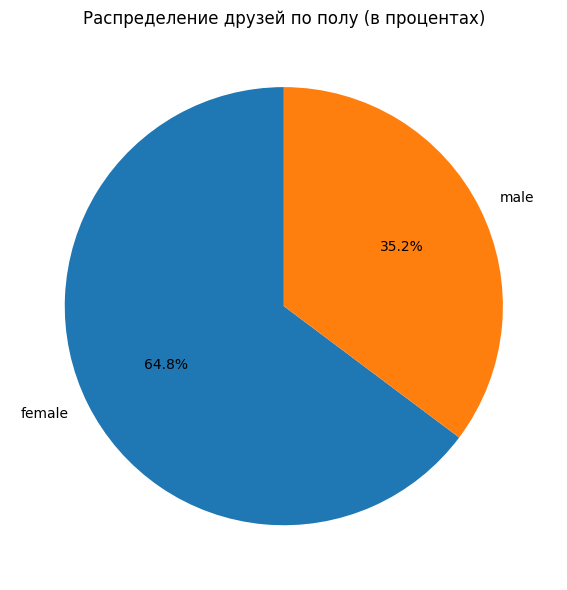

In [ ]:
plt.figure(figsize=(6, 6))

plt.pie(
    sex_stats["percent"],
    labels=sex_stats["sex_label"],
    autopct="%1.1f%%",
    startangle=90
)

plt.title("Распределение друзей по полу (в процентах)")
plt.tight_layout()
plt.show()

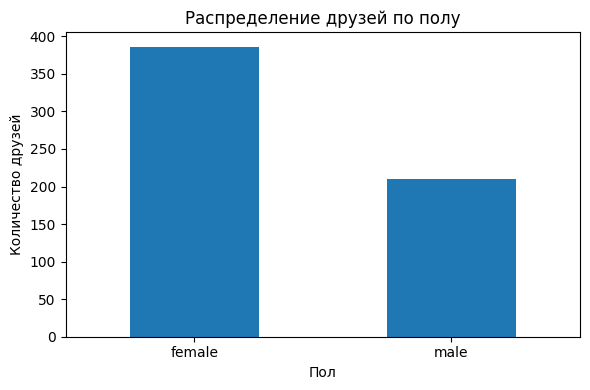

In [ ]:
sex_counts = df["sex_label"].value_counts()

plt.figure(figsize=(6, 4))
sex_counts.plot(kind="bar")
plt.title("Распределение друзей по полу")
plt.xlabel("Пол")
plt.ylabel("Количество друзей")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Возрастные группы

In [ ]:
age_group_stats = (
    df.groupby("age_group")
    .size()
    .reset_index(name="count")
    .assign(percent=lambda x: x["count"] / x["count"].sum() * 100)
    .sort_values("age_group")
)

age_group_stats

,age_group,count,percent
0,18–24,258,43.288591
1,25–34,136,22.818792
2,35–44,59,9.899329
3,45–54,33,5.536913
4,55–64,21,3.523490
5,65+,20,3.355705
6,<18,69,11.577181


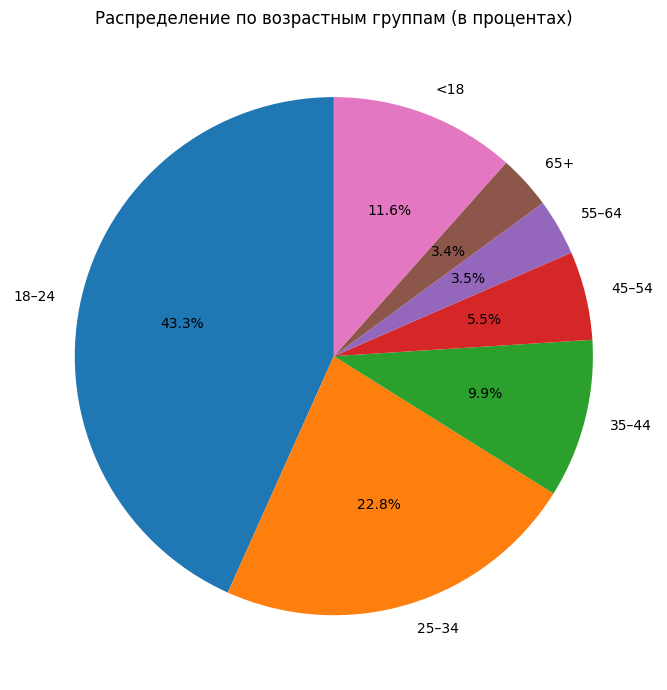

In [ ]:
plt.figure(figsize=(7, 7))
plt.pie(
    age_group_stats["percent"],
    labels=age_group_stats["age_group"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Распределение по возрастным группам (в процентах)")
plt.tight_layout()
plt.show()

### Статистика по возрасту и полу

In [ ]:
age_stats_by_sex = (
    df[df["age"].notna()]
    .groupby("sex_label")["age"]
    .agg(
        mean_age="mean",
        median_age="median",
        min_age="min",
        max_age="max"
    )
    .round(1)
)

age_stats_by_sex


,mean_age,median_age,min_age,max_age
sex_label,,,,
female,29.9,24.0,14.0,115.0
male,25.8,22.0,15.0,120.0


### Таблица распределения возрастных групп и пола

In [ ]:
df_filtered = df[
    (df["age_group"] != "unknown") &
    (df["sex_label"] != "unknown")
]

age_sex_table_count = pd.crosstab(
    df_filtered["age_group"],
    df_filtered["sex_label"],
    margins=True,
    margins_name="Total",
)

age_sex_table_count

sex_label,female,male,Total
age_group,,,
18–24,155,103,258
25–34,86,50,136
35–44,44,15,59
45–54,24,9,33
55–64,18,3,21
65+,16,4,20
<18,43,26,69
Total,386,210,596


### Топ-5 городов

In [ ]:
city_stats = (
    df.dropna(subset=["city_title"])
    .groupby("city_title")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

city_stats.head(5)

,city_title,count
17,Ulyanovsk,234
7,Moscow,13
12,Saint Petersburg,3
4,Dimitrovgrad,3
9,Nizhny Novgorod,2


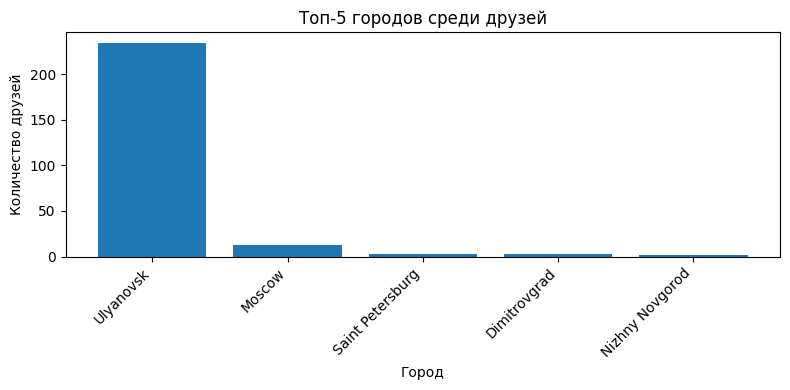

In [ ]:
top_5_cities = city_stats.head(5)

plt.figure(figsize=(8, 4))
plt.bar(top_5_cities["city_title"], top_5_cities["count"])
plt.title("Топ-5 городов среди друзей")
plt.xlabel("Город")
plt.ylabel("Количество друзей")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()